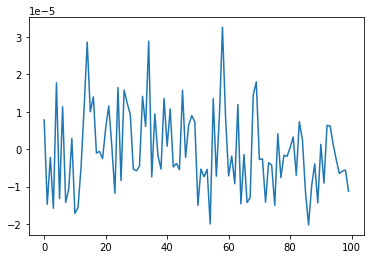

In [2]:


import numpy as np
import numpy.random as rnd
import torch
import torch.nn as nn
import torch.optim as optim
import math
import mat73
import matplotlib.pyplot as plt


# setting up GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load the data from matlab
file_name = 'F:/UCB-UCSF Career/decimated_lstm_data_below25Hz_old.mat'
data_dict = mat73.loadmat(file_name)
condn_data_new = data_dict.get('condn_data_new')
Y = data_dict.get('Y')


# artifact correction, geting rid of large artifacts
for i in np.arange(condn_data_new.shape[2]):

    # first 128 features -> these are high gamma
    xx = condn_data_new[:,0:128,i]
    I = np.abs(xx)>15
    I = np.sum(I,0)
    aa = (np.where(I>0))    
    tmp= np.squeeze(xx[:,aa])
    shape_tmp = list(tmp.shape)
    
    
    if np.size(shape_tmp)==1:
         shape_tmp.append(1)    
        
    tmp_rand = rnd.randn(shape_tmp[0],shape_tmp[1])    
    xx[:,aa[0]] = 1e-5*tmp_rand    
    condn_data_new[:,0:128,i] = xx    
    
    # second 128 features -> these are DC-25Hz 
    xx = condn_data_new[:,128:,i]
    I = np.abs(xx)>15
    I = np.sum(I,0)
    aa = (np.where(I>0))
    tmp= np.squeeze(xx[:,aa])
    shape_tmp = list(tmp.shape)
    
    if np.size(shape_tmp)==1:
        shape_tmp.append(1)    
        
    tmp_rand = rnd.randn(shape_tmp[0],shape_tmp[1])    
    xx[:,aa[0]] = 1e-5*tmp_rand    
    condn_data_new[:,128:,i] = xx    
    

# look at it 
tmp = np.squeeze(condn_data_new[:,66,1])
plt.plot(tmp)

In [ ]:
# # data augmentation on the training samples  -> introduce random noise plus random shift to each  training sample
# Xtrain_aug = np.zeros(Xtrain.shape)
# len = Xtrain.shape[2]
# for i in np.arange(len):
#
#     print(i)
#
#     tmp = np.squeeze(Xtrain[:,:,i])
#     tid = Ytrain[i]
#
#     # first 128, high gamma
#     tmp1 = tmp[:,:128]
#     # add noise
#     var_noise = 0.7
#     std_dev = np.std(np.concatenate(tmp1))
#     add_noise = rnd.randn(tmp1.shape[0],tmp1.shape[1]) * std_dev * var_noise
#     tmp1n = tmp1 + add_noise
#     #plt.figure();plt.plot(tmp1[:,13]);plt.plot(tmp1n[:,13]);plt.show()
#     # add variable mean offset
#     m=np.mean(tmp1,0)
#     add_mean = m*0.25
#     flip_sign = rnd.rand(add_mean.shape[0])
#     flip_sign[flip_sign>0.5]=1
#     flip_sign[flip_sign<=0.5]=-1
#     add_mean = np.multiply(flip_sign,add_mean) + m
#     tmp1m = tmp1n + add_mean
#     #tmp1m  = (tmp1m-tmp1m.min())/(tmp1m.max()-tmp1m.min())
#     #plt.figure();plt.plot(tmp1[:,13]);plt.plot(tmp1m[:,13]);plt.show()
#
#     # next 128, LFOs
#     tmp2 = tmp[:,128:]
#     # add noise
#     var_noise = 0.7
#     std_dev = np.std(np.concatenate(tmp2))
#     add_noise = rnd.randn(tmp2.shape[0],tmp2.shape[1]) * std_dev * var_noise
#     tmp2n = tmp2 + add_noise
#     #plt.figure();plt.plot(tmp2[:,13]);plt.plot(tmp2n[:,13]);plt.show()
#     # add variable mean offset
#     m=np.mean(tmp2,0)
#     add_mean = m*0.5
#     flip_sign = rnd.rand(add_mean.shape[0])
#     flip_sign[flip_sign>0.5]=1
#     flip_sign[flip_sign<=0.5]=-1
#     add_mean = np.multiply(flip_sign,add_mean) + m
#     tmp2m = tmp2n + add_mean
#     #tmp2m  = (tmp2m-tmp2m.min())/(tmp2m.max()-tmp2m.min())
#     #plt.figure();plt.plot(tmp2[:,13]);plt.plot(tmp2m[:,13]);plt.show()
#
#     tmp=np.concatenate((tmp1m,tmp2m),axis=1)
#
#     Ytrain = np.append(Ytrain,tid)
#     Xtrain_aug[:,:,i] =tmp
#     #Xtrain[:,:,Xtrain.shape[2]+1] = tmp
#     #Xtrain=np.dstack((Xtrain,tmp))
#     #Xtrain = np.append(Xtrain,np.atleast_3d(tmp),axis=2)
#     #Xtrain = np.concatenate((Xtrain,np.atleast_3d(tmp)),axis=2)
#
# del condn_data_new
# Xtrain = np.concatenate((Xtrain,Xtrain_aug),axis=2)
# del Xtrain_aug
#
# print('Data augmentation also done')

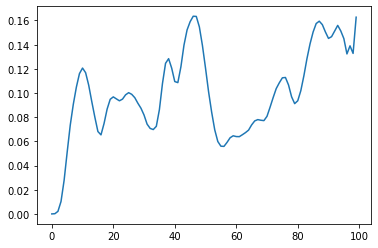

In [3]:
# normalize , min max scaling 
for i in np.arange(condn_data_new.shape[2]):
    tmp = np.squeeze(condn_data_new[:,:,i])
    tmp1 = tmp[:,:128]
    tmp1  = (tmp1-tmp1.min())/(tmp1.max()-tmp1.min())
    
    tmp2 = tmp[:,128:]
    tmp2  = (tmp2-tmp2.min())/(tmp2.max()-tmp2.min())
    
    tmp = np.concatenate((tmp1,tmp2),axis=1)
    condn_data_new[:,:,i] = tmp
    
# look at it 
tmp = np.squeeze(condn_data_new[:,66,144])
plt.figure()
plt.plot(tmp)

In [4]:
# split into testing and training samples randomly
len = np.arange(condn_data_new.shape[2])
len_cutoff = round(0.85*len[-1])
idx = np.random.permutation(condn_data_new.shape[2])
train_idx, test_idx = idx[:len_cutoff] , idx[len_cutoff:]
Xtrain, Xtest = condn_data_new[:,:,train_idx] , condn_data_new[:,:,test_idx] 
Ytrain, Ytest = Y[train_idx] , Y[test_idx]

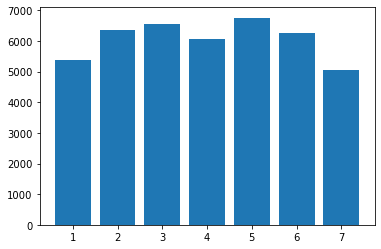

In [5]:
class_mem = np.empty([0])
for i in np.arange(7):
    class_mem = np.append(class_mem, np.sum(Ytrain==(i+1)))

plt.figure()
plt.bar(np.arange(7)+1,class_mem)

del condn_data_new

# now convert integer to multinomial rerepsentation for classfication
Ytrain_mult = np.zeros((Ytrain.shape[0],7))
for i in range(Ytrain.shape[0]):
    tmp = round(Ytrain[i])-1
    Ytrain_mult[i,tmp]=1

Ytrain = Ytrain_mult
del Ytrain_mult

Ytest_mult = np.zeros((Ytest.shape[0],7))
for i in range(Ytest.shape[0]):
    tmp = round(Ytest[i])-1
    Ytest_mult[i,tmp]=1

Ytest = Ytest_mult
del Ytest_mult

In [6]:
class rnn_gru(nn.Module):
    def __init__(self,num_classes,input_size,hidden_size,num_layers,dropout_val):
        super(rnn_gru,self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size       
        
        self.rnn1=nn.LSTM(input_size=input_size,hidden_size=hidden_size,
                          num_layers=num_layers,batch_first=True,dropout=dropout_val,
                          bidirectional=True)
        self.rnn2=nn.GRU(input_size=round(hidden_size*2),hidden_size=round(hidden_size/2),
                          num_layers=num_layers,batch_first=True, bidirectional=False)
        
        self.mlp_input = round(hidden_size/2)
        self.linear1 = nn.Linear(self.mlp_input,num_classes)
    
    def forward(self,x):        
        output1, (hn1,cn1) = self.rnn1(x) 
        output2, (hn2) = self.rnn2(output1)
        hn2 = torch.squeeze(hn2)        
        out = self.linear1(hn2)        
        return out

In [7]:
# lstm parameters
input_size=256
hidden_size=150
num_layers=1
sequence_length = 100
num_classes=7
dropout_val=0.3

#init model
model = rnn_gru(num_classes,input_size,hidden_size,num_layers,dropout_val)
model = model.to(device) #push to GPU

# training parameters
num_epochs=100
batch_size = 256
gradient_clipping = 10.0
learning_rate=2e-4
opt = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(reduction='mean')
num_batches = math.ceil(Xtrain.shape[2]/batch_size)
patience=6
len = Xtrain.shape[2]
batch_val=512 

# coverting data to torch tensors and pushing to GPU
Ytest = torch.from_numpy(Ytest).float()
Xtest = torch.from_numpy(Xtest).float()
Xtest= torch.permute(Xtest,(2,0,1)) # N,seq_length,Dimension

e:\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [8]:
# function to convert one-hot representation back to class numbers
def convert_to_ClassNumbers(indata):
    with torch.no_grad():
        outdata = torch.max(indata,1).indices
    
    return outdata
    
# function to get validation loss 
def validation_loss(model,X_test,Y_test,batch_val,val_type):    
    crit_val = nn.CrossEntropyLoss(reduction='sum')
    loss_val=0    
    accuracy=0
    if batch_val > X_test.shape[0]:
        batch_val = X_test.shape[0]
        
    idx=np.arange(0,X_test.shape[0],batch_val)    
    if idx[-1]<X_test.shape[0]:
        idx=np.append(idx,X_test.shape[0])
    else:
        print('something wrong here')
    
    iters=(idx.shape[0]-1)
    
    for i in np.arange(iters):
        x=X_test[idx[i]:idx[i+1],:,:]
        y=Y_test[idx[i]:idx[i+1],:]
        x=x.to(device)
        y=y.to(device)
        if val_type==1: #validation
            model.eval()
            ypred = model(x)
            model.train()
        else:
            ypred = model(x) #usually just the last training batch
        with torch.no_grad():
            loss_val += (crit_val(ypred,y).item())    
        
        ylabels = convert_to_ClassNumbers(y)        
        ypred_labels = convert_to_ClassNumbers(ypred)     
        accuracy += torch.sum(ylabels == ypred_labels).item()
                    
    loss_val=loss_val/X_test.shape[0]
    accuracy = accuracy/X_test.shape[0]
    torch.cuda.empty_cache()
    return loss_val,accuracy


In [9]:
val_loss,val_acc = validation_loss(model,Xtest,Ytest,batch_val,1)
torch.cuda.empty_cache()
print(val_loss,val_acc)

filename='lstm_model.pth'
goat_loss=99999
counter=0
for epoch in range(num_epochs):
  #shuffle the data    
  idx = rnd.permutation(len) 
  
    
  for batch in range(num_batches):
      # get the batch 
      k = batch*batch_size
      k1 = k+batch_size
      samples = idx[k:k1]
      Xtrain_batch = Xtrain[:,:,samples]
      Ytrain_batch = Ytrain[samples,:]        
      
      #push to gpu
      Xtrain_batch = torch.from_numpy(Xtrain_batch).float()
      Ytrain_batch = torch.from_numpy(Ytrain_batch).float()    
      Xtrain_batch = torch.permute(Xtrain_batch,(2,0,1)) # N,seq_length,Dimensions      
      Xtrain_batch = Xtrain_batch.to(device)
      Ytrain_batch = Ytrain_batch.to(device)
      
      # pass thru network
      opt.zero_grad() 
      Ypred = model(Xtrain_batch)
      loss = criterion(Ypred,Ytrain_batch)
      #print(loss.item())
      loss.backward()
      nn.utils.clip_grad_value_(model.parameters(), clip_value=gradient_clipping)
      opt.step()
      
  val_loss,val_acc=validation_loss(model,Xtest,Ytest,batch_val,1)  
  train_loss,train_acc=validation_loss(model,Xtrain_batch,Ytrain_batch,
                                       round(batch_size/2),0)  
  print(val_loss,val_acc*100,train_loss,train_acc*100,)
  
  if val_loss<goat_loss:
      goat_loss = val_loss
      counter = 0
      print('Goat loss, saving model')      
      torch.save(model.state_dict(), filename)
  else:
      counter += 1

  if counter>=patience:
      print('Early stoppping point reached')
      print('Best val loss is')
      print(goat_loss)
      break

1.9604369660667031 0.11299585948978229
1.5664715405791914 34.3662348069988 1.5692550323821686 30.76923076923077
Goat loss, saving model
1.4581648881498765 40.189662080940295 1.5166089822957805 30.21978021978022
Goat loss, saving model
1.3505947785080077 46.373714438359826 1.372116927262191 43.956043956043956
Goat loss, saving model
1.2829253322947276 49.29878455990384 1.3225177722972827 44.505494505494504
Goat loss, saving model
1.2529250081651946 50.166956057165756 1.195822034563337 51.098901098901095
Goat loss, saving model
1.236830550232382 50.87484973954856 1.1343971503959906 55.494505494505496
Goat loss, saving model
1.1483964131578068 56.71163349806331 1.1658349299168849 55.494505494505496
Goat loss, saving model
1.123511433489924 57.00547615867504 1.082643571790758 59.34065934065934
Goat loss, saving model
1.1066723336074196 57.49966608788567 1.080890865116329 59.34065934065934
Goat loss, saving model
1.031642342658264 61.2929077066916 0.9695652343414642 65.38461538461539
Goat l

In [ ]:
Xtest,Ytest,batch_val

In [11]:
Xtest.shape

torch.Size([7487, 100, 256])

In [ ]:
def validation_output(model,X_test,Y_test,batch_val,val_type):    
    crit_val = nn.CrossEntropyLoss(reduction='sum')
    loss_val=0    
    accuracy=0
    if batch_val > X_test.shape[0]:
        batch_val = X_test.shape[0]
        
    idx=np.arange(0,X_test.shape[0],batch_val)    
    if idx[-1]<X_test.shape[0]:
        idx=np.append(idx,X_test.shape[0])
    else:
        print('something wrong here')
    
    iters=(idx.shape[0]-1)
    
    for i in np.arange(iters):
        x=X_test[idx[i]:idx[i+1],:,:]
        y=Y_test[idx[i]:idx[i+1],:]
        x=x.to(device)
        y=y.to(device)
        if val_type==1: #validation
            model.eval()
            ypred = model(x)
            model.train()
        else:
            ypred = model(x) #usually just the last training batch
        with torch.no_grad():
            loss_val += (crit_val(ypred,y).item())    
        
        ylabels = convert_to_ClassNumbers(y)        
        ypred_labels = convert_to_ClassNumbers(ypred)     
        accuracy += torch.sum(ylabels == ypred_labels).item()
                    
    loss_val=loss_val/X_test.shape[0]
    accuracy = accuracy/X_test.shape[0]
    torch.cuda.empty_cache()
    return loss_val,accuracy
